# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Compute the $Q_0$

In this notebook we use the LR matches of the first round of LR for the r-band to improve the accuracy of the W1 band $Q_0$

## Configuration

### Load libraries and setup

In [1]:
import os
import sys
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output

In [2]:
try:
    BASEPATH = os.path.dirname(os.path.realpath(__file__))
    data_path = os.path.join(BASEPATH, "..", "..", "data")
except NameError:
    if os.path.exists("data"):
        BASEPATH = "."
        data_path = os.path.join(BASEPATH, "data")
    else:
        BASEPATH = os.getcwd()
        data_path = os.path.join(BASEPATH, "..", "..", "data")

In [3]:
sys.path.append(os.path.join(BASEPATH, "..", "..", "src"))
from mltier1 import Field, Q_0, parallel_process, describe

In [64]:
idp = os.path.join(BASEPATH, "..", "..", "data", "idata", "main")

In [4]:
%load_ext autoreload

In [5]:
%autoreload

In [6]:
from IPython.display import clear_output

In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

### Area limits

In [9]:
margin_ra = 0.1
margin_dec = 0.1

In [10]:
# # Test samples P005p28.fits
# dec_down = 27.206
# dec_up = 29.8
# ra_down = 4.025
# ra_up = 7.08

# # Test samples LoTSS_DR2_RA0INNER_v0.9.srl
# dec_down = 27.7
# dec_up = 34.
# ra_down = 6.
# ra_up = 20.5

# Test samples LoTSS_DR2_DUMMYCAT_FORPEPE_0h.srl.fits
dec_down = 22.25
dec_up = 32.
ra_down = 0.
ra_up = 20.5

In [11]:
field = Field(ra_down, ra_up, dec_down, dec_up)

In [12]:
field_optical = Field(
    ra_down - margin_ra, 
    ra_up + margin_ra, 
    dec_down - margin_dec, 
    dec_up + margin_dec)

## Load data

In [13]:
combined_all = Table.read(os.path.join(data_path, "samples", "test_combined.fits"))

In [14]:
#lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.9.srl.fits")
#lofar_all = Table.read(os.path.join(data_path, "samples", "P005p28.fits"))
lofar_all = Table.read(os.path.join(data_path, "samples", "LoTSS_DR2_DUMMYCAT_FORPEPE_0h.srl.fits"))

In [15]:
np.array(combined_all.colnames)

array(['RA', 'DEC', 'UID_L', 'UNWISE_OBJID', 'MAG_R', 'MAG_W1', 'MAG_W2'],
      dtype='<U12')

In [16]:
np.array(lofar_all.colnames)

array(['Source_Name', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Peak_flux',
       'E_Peak_flux', 'Total_flux', 'E_Total_flux', 'Maj', 'E_Maj', 'Min',
       'E_Min', 'DC_Maj', 'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'PA', 'E_PA',
       'DC_PA', 'E_DC_PA', 'Isl_rms', 'S_Code', 'Mosaic_ID'], dtype='<U12')

### Filter catalogues

In [68]:
lofar = field.filter_catalogue(
    lofar_all[(lofar_all["Maj"] < 30.0)], colnames=("RA", "DEC")
)

In [69]:
combined = field.filter_catalogue(combined_all, colnames=("RA", "DEC"))

In [70]:
print(len(lofar_all), len(lofar))

516404 100207


In [71]:
print(len(combined_all), len(combined))

117758023 14146049


### Sky coordinates

In [72]:
coords_combined = SkyCoord(
    combined["RA"], combined["DEC"], unit=(u.deg, u.deg), frame="icrs"
)

In [73]:
coords_lofar = SkyCoord(lofar["RA"], lofar["DEC"], unit=(u.deg, u.deg), frame="icrs")

### Summary of galaxy types in the combined catalogue

In [74]:
combined_legacy = (
    ~np.isnan(combined["MAG_R"])
    & ~np.isnan(combined["MAG_W1"])
    & ~np.isnan(combined["MAG_W2"])
)
np.sum(combined_legacy)  # Matches

12469235

In [75]:
combined_matched = ~np.isnan(combined["MAG_R"]) & (combined["UNWISE_OBJID"] != "N/A")
np.sum(combined_matched)

4314528

In [76]:
combined_legacy_only = ~np.isnan(combined["MAG_R"]) & (
    combined["UNWISE_OBJID"] == "N/A"
)
np.sum(combined_legacy_only)  # Only Legacy

8154707

In [77]:
print(np.sum(combined_legacy))
print(np.sum(combined_matched) + np.sum(combined_legacy_only))

12469235
12469235


In [78]:
combined_wise = np.isnan(combined["MAG_R"]) & (~np.isnan(combined["MAG_W1"]))
np.sum(combined_wise)  # Only WISE

1478875

In [79]:
combined_wise2 = np.isnan(combined["MAG_R"]) & np.isnan(combined["MAG_W1"])
np.sum(combined_wise2)  # Only WISE2

197939

In [80]:
print(len(combined))
print(np.sum(combined_legacy) + np.sum(combined_wise) + np.sum(combined_wise2))

14146049
14146049


## $Q_0$ dependence on the radius

We will iterate 10 times for each radius.

In [81]:
n_iter = 10

In [57]:
rads = list(range(1,26))

### r-band

In [58]:
q_0_comp_r = Q_0(coords_lofar, coords_combined[combined_legacy], field)

In [ ]:
q_0_rad_r = []
q_0_rad_r_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        try:
            out = q_0_comp_r(radius=radius)
        except ZeroDivisionError:
            continue
        else:
            q_0_rad_aux.append(out)
    q_0_rad_r.append(np.mean(q_0_rad_aux))
    q_0_rad_r_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.46474 +/- 0.00019 [0.46441 0.46504]
 2 0.62428 +/- 0.00031 [0.62358 0.62483]
 3 0.66658 +/- 0.00041 [0.66614 0.66731]
 4 0.68808 +/- 0.00069 [0.68645 0.68903]
 5 0.69852 +/- 0.00111 [0.69682 0.70005]
 6 0.70438 +/- 0.00080 [0.70317 0.70592]
 7 0.70954 +/- 0.00112 [0.70771 0.71118]
 8 0.71578 +/- 0.00114 [0.71388 0.71693]
 9 0.71841 +/- 0.00138 [0.71605 0.72083]
10 0.72176 +/- 0.00130 [0.71891 0.72348]
11 0.72609 +/- 0.00301 [0.72038 0.73322]
12 0.72846 +/- 0.00159 [0.72581 0.73049]
13 0.72863 +/- 0.00345 [0.72041 0.73237]
14 0.73282 +/- 0.00468 [0.72377 0.73834]
15 0.73179 +/- 0.00437 [0.72322 0.73614]


(0, 1)

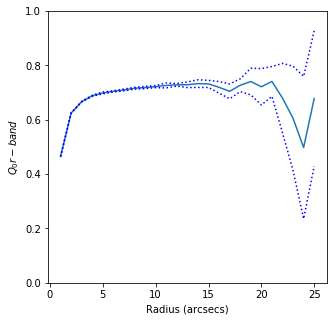

In [61]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, q_0_rad_r)
plt.plot(rads, np.array(q_0_rad_r) + 3 * np.array(q_0_rad_r_std), ls=":", color="b")
plt.plot(rads, np.array(q_0_rad_r) - 3 * np.array(q_0_rad_r_std), ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 r-band$")
plt.ylim([0, 1])

### W1-band

In [65]:
lr_saved = np.load(os.path.join(idp, "lr_r.npz"))["lr_r"]

In [83]:
len(lr_saved)

100207

In [82]:
len(coords_lofar)

100207

In [84]:
coords_lofar_alt = coords_lofar[lr_saved["lr_r"] <= 0.8584698995739861]

In [87]:
len(coords_lofar_alt)

35073

In [89]:
base_factor = len(coords_lofar_alt)/len(coords_lofar)

In [85]:
q_0_comp_w1 = Q_0(coords_lofar_alt, coords_combined[combined_wise], field)

In [86]:
q_0_rad_w1 = []
q_0_rad_w1_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w1(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w1.append(np.mean(q_0_rad_aux))
    q_0_rad_w1_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.14002 +/- 0.00016 [0.13975 0.14034]
 2 0.26880 +/- 0.00029 [0.26837 0.26929]
 3 0.32764 +/- 0.00045 [0.32717 0.32865]
 4 0.35784 +/- 0.00060 [0.35700 0.35896]
 5 0.37635 +/- 0.00074 [0.37495 0.37722]
 6 0.38897 +/- 0.00087 [0.38760 0.39067]
 7 0.39781 +/- 0.00095 [0.39607 0.39921]
 8 0.40383 +/- 0.00135 [0.40131 0.40626]
 9 0.40918 +/- 0.00080 [0.40755 0.40998]
10 0.41336 +/- 0.00143 [0.41075 0.41513]
11 0.41648 +/- 0.00174 [0.41341 0.41953]
12 0.42137 +/- 0.00181 [0.41899 0.42436]
13 0.42346 +/- 0.00141 [0.42098 0.42615]
14 0.42544 +/- 0.00193 [0.42310 0.42868]
15 0.42666 +/- 0.00194 [0.42302 0.42944]
16 0.42838 +/- 0.00330 [0.42479 0.43505]
17 0.43050 +/- 0.00253 [0.42769 0.43671]
18 0.43372 +/- 0.00323 [0.42930 0.43922]
19 0.43486 +/- 0.00279 [0.42930 0.43948]
20 0.43896 +/- 0.00399 [0.43217 0.44492]
21 0.43891 +/- 0.00229 [0.43433 0.44291]
22 0.43930 +/- 0.00327 [0.43502 0.44472]
23 0.44041 +/- 0.00421 [0.43393 0.44819]
24 0.43989 +/- 0.00388 [0.43284 0.44503]
25 0.43935 +/- 0

In [90]:
q_0_rad_w1 = np.array(q_0_rad_w1)
q_0_rad_w1_std = np.array(q_0_rad_w1_std)

(0, 0.2)

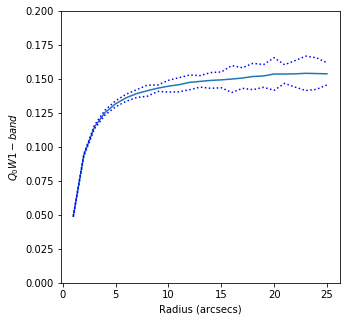

In [92]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, base_factor * q_0_rad_w1)
plt.plot(rads, base_factor * q_0_rad_w1 + 3 * q_0_rad_w1_std, ls=":", color="b")
plt.plot(rads, base_factor * q_0_rad_w1 - 3 * q_0_rad_w1_std, ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 W1-band$")
plt.ylim([0, 0.2])

In [93]:
0.41648 * base_factor

0.1457702859081701

### W2-band

Load the LR of W1. These, combined with those of r-band will be used to discard the galaxies that have already a good match above the likelihood threshold.

In [94]:
lr_w1_saved = np.load(os.path.join(idp, "lr_w1.npz"))["lr_w1"]

In [95]:
len(lr_w1_saved)

100207

In [97]:
coords_lofar_alt2 = coords_lofar[
    (lr_saved["lr_r"] <= 0.8584698995739861) &
    (lr_w1_saved["lr_w1"] <= 3.38560307030821)
]

In [100]:
base_factor2 = len(coords_lofar_alt2)/len(coords_lofar)

In [101]:
print(base_factor2)

0.2503617511750676


In [98]:
q_0_comp_w2 = Q_0(coords_lofar_alt2, coords_combined[combined_wise2], field)

In [99]:
q_0_rad_w2 = []
q_0_rad_w2_std = []
for radius in rads:
    q_0_rad_aux = []
    for i in range(n_iter):
        out = q_0_comp_w2(radius=radius)
        q_0_rad_aux.append(out)
    q_0_rad_w2.append(np.mean(q_0_rad_aux))
    q_0_rad_w2_std.append(np.std(q_0_rad_aux))
    print(
        "{:2d} {:7.5f} +/- {:7.5f} [{:7.5f} {:7.5f}]".format(
            radius,
            np.mean(q_0_rad_aux),
            np.std(q_0_rad_aux),
            np.min(q_0_rad_aux),
            np.max(q_0_rad_aux),
        )
    )

 1 0.00818 +/- 0.00005 [0.00809 0.00829]
 2 0.02052 +/- 0.00012 [0.02035 0.02075]
 3 0.02979 +/- 0.00029 [0.02922 0.03019]
 4 0.03670 +/- 0.00040 [0.03605 0.03744]
 5 0.04216 +/- 0.00024 [0.04186 0.04248]
 6 0.04531 +/- 0.00047 [0.04452 0.04613]
 7 0.04869 +/- 0.00071 [0.04762 0.04985]
 8 0.05179 +/- 0.00127 [0.04962 0.05443]
 9 0.05478 +/- 0.00089 [0.05374 0.05693]
10 0.05656 +/- 0.00070 [0.05531 0.05744]
11 0.05796 +/- 0.00083 [0.05669 0.05986]
12 0.05925 +/- 0.00127 [0.05660 0.06093]
13 0.05959 +/- 0.00115 [0.05725 0.06180]
14 0.06068 +/- 0.00115 [0.05809 0.06207]
15 0.06149 +/- 0.00099 [0.05954 0.06268]
16 0.06319 +/- 0.00099 [0.06117 0.06460]
17 0.06225 +/- 0.00108 [0.06017 0.06448]
18 0.06272 +/- 0.00334 [0.05691 0.06785]
19 0.06553 +/- 0.00179 [0.06196 0.06850]
20 0.06679 +/- 0.00236 [0.06373 0.07138]
21 0.06808 +/- 0.00211 [0.06505 0.07162]
22 0.06779 +/- 0.00245 [0.06419 0.07152]
23 0.07126 +/- 0.00160 [0.06878 0.07357]
24 0.07153 +/- 0.00222 [0.06804 0.07495]
25 0.07253 +/- 0

In [103]:
q_0_rad_w2 = np.array(q_0_rad_w2)
q_0_rad_w2_std = np.array(q_0_rad_w2_std)

(0, 0.03)

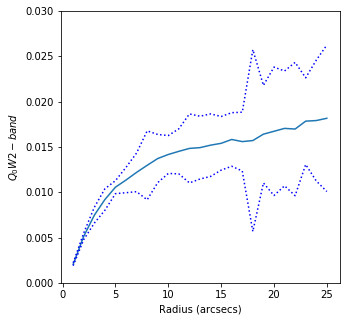

In [106]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(rads, base_factor2 * q_0_rad_w2)
plt.plot(rads, base_factor2 * q_0_rad_w2 + 3 * q_0_rad_w2_std, ls=":", color="b")
plt.plot(rads, base_factor2 * q_0_rad_w2 - 3 * q_0_rad_w2_std, ls=":", color="b")
plt.xlabel("Radius (arcsecs)")
plt.ylabel("$Q_0 W2-band$")
plt.ylim([0, 0.03])

In [107]:
0.06319 * base_factor2

0.015820359056752522